Как обычно, мы начнем демонстрацию нового алгоритма на уже давно знакомой нам среде - `pong`. Чтобы запустить эту среду, необходимо сначала скачать некоторые дополнительные файлы:

In [ ]:
#В связи с недавним обновлением библиотеки gym, попытки создать игровую среду pong-v0 (или любую другую) теперь вызывают ошибку. 
#Следующий код является временной мерой для избежание этой ошибки.
#Здесь меняется версия библиотек. Этот код был добавлен 28 мая. Когда обновят gym и уберут критичный баг, этот код будет удален.

!pip install gym==0.18.0
!pip install atari-py==0.2.5
!pip install imageio==2.4.1

     |████████████████████████████████| 1.6 MB 5.2 MB/s 
  Created wheel for gym: filename=gym-0.18.0-py3-none-any.whl size=1656448 sha256=0d0301a93ed288e5b3a0f964828aa3328410702698105414e7ef0ed3f610d0c4
  Stored in directory: /root/.cache/pip/wheels/99/f7/e3/d6f0f120ac047c1e5de2ae34930e7bf6e8de1c7a4d5fa68555
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 2.8 MB 5.1 MB/s 
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


Подключаем нужные библиотеки:

In [ ]:
import gym         # Load the Gym module from OpenAi, which is an environment for reinforcement learning
import numpy as np # Import numpy
import tensorflow.keras as keras        # Import keras
from tensorflow.keras.models import Model, load_model # From keras import the class Model and the function load_model separately
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Conv2D, MaxPooling2D, Reshape, Multiply # From keras import common layers
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, Adam, SGD # From keras load these optimizers
from tensorflow.keras import backend as K
import time                                # Import the time module
import matplotlib.pyplot as plt            # Import matplotlib pyplot for data visualization
import tensorflow as tf               #Import tensorflow
import math
import cv2
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках
 
# Python magic function to make pyplot compatible with IPython
%matplotlib inline

Далее, мы прогоним строку кода, которая отключит eager execution в тензорфлоу (включена по умолчанию). Это немного ограничивает нас в коде, который мы можем писать, однако в результате этого нейронная сеть будет работать на порядок быстрее. 

Нужно отметить что этот эффект услорение действует на модели, которые созданы через Functional API либо через Sequential API. Модели, которые созданы через ООП, наоборот будут работать медленее, чем при включенном eager execution.

In [ ]:
#Выключаем eager execution в Тензорфлоу, чтобы сеть могла работать (в частности, предсказывать данные) намного быстрее.
tf.compat.v1.disable_eager_execution()

Подключаем гугл-диск:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Код для создания среды, прочие функции из предыдущих занятий

Этот код не менялся из предыдущих занятий, по этому его можно скрыть. Данный код просто задает различные функции, создания среды, и прочие вещи с которыми мы уже знакомы.

In [ ]:
#Код из занятия по градиентной политики!!!
#Этот код ни как не поменялся - он лишь создает среду и задает различные полезные функции

import gym         #Импортируем библиотеку gym (встроенная в колаб)
import numpy as np #Импортируем numpy
from tensorflow.keras.models import Model, load_model #Импортируем функцию для создания модели и загрузки модели
from tensorflow.keras.layers import * #Импортируем все слои кераса
from tensorflow.keras.optimizers import RMSprop #Импортируем оптимизатор RMSprop
import tensorflow as tf                    #Импортируем тензорфлоу
import matplotlib.pyplot as plt            #Импортируем pyplot для визуализации данных
import pickle                              #Импортируем модуль pickle для сохранения и загрузки данных
from moviepy.editor import *               #Импортируем полезные функции из библиотеки для возпроизведение видео с результатом
import cv2                                 #Импортируем библиотеку cv2 (используется для воспроизведение видео)
from google.colab import output            #Импортируем функцию для управления вывода в колаб-ячейках

env = gym.make('Pong-v4')                              # Создаем среду Pong
new_frame = env.reset()                                # Запускаем среду (это действие возвращает начальное состояние)
print(f"Размерность состояния: {new_frame.shape}")     # Взглянем на размерность состояния

action_space = [2, 3] #Создаем массив возможных действий. Агент может стоять на месте, двигаться влево, или двигаться вправо.
num_actions = len(action_space) #Записываем в переменную количество уникальных возможных действий - также известно как размерность пространства действий.

#Создадим функцию для предобработки кадра - превращает цвет в чёрно-белый, отсекает ненужные части кадра, и сжимает.
def preprocess_frame(frame):       #Функция принимает кадр на вход
  frame = frame.astype(np.float32) #Меняем тип данных на float32

  frame = frame[35:195]            #Отсекаем ненужные части кадра, которые не пренадлежат игровому полю.
  frame = frame[::2, ::2, 0]       #Сжимаем изображение (берём каждый второй пиксель)

  frame[frame == 144] = 0          #Удаляем фон (меняем на чёрный цвет - значение пикселя = 0)
  frame[frame == 109] = 0          #Удаляем фон (меняем на чёрный цвет - значение пикселя = 0)
  frame[frame != 0] = 1            #Всё, что не пренадлежит фону, меняем на белый цвет (значение пикселя = 1)
  return frame.reshape(80, 80, 1)  #Меняем форму итогового кадра на (80, 80, 1)

#Создадим функцию для "склеивание" двух кадров - этот процесс даст нам текущее состояние, которое будет подаваться на вход нейронной сети.
def stack_frames(new_frame, old_frame):                    #Функция принимает два изображения на вход: новое и старое                   
  new_frame = preprocess_frame(new_frame)                  #Предобрабатываем новое изображение (используем выше объявленную функцию)
  old_frame = preprocess_frame(old_frame)                  #Предобрабатываем старое изображение (используем выше объявленную функцию)
  return new_frame - old_frame #Склеиваем изображения по 3-й (канальной) оси, и возвращаем.

#Создадим функцию для предобработки наград
def preprocess_rewards(rewards_list):
  discounted_rewards = np.zeros_like(rewards_list)      #Инициализируем массив обработанных наград нулями
  running_add = 0                                       #running_add содержит предобработанную награду, которая назначается за действие - инициализируется нулем.
  for i in reversed(range(len(discounted_rewards))):    #Итерируем через массив наград в обратном порядке.
    if rewards_list[i] != 0:                            #Если на заданный момент есть не-нулевая награда, которая была назначена средой: 
      running_add = 0                                   #переменная running_add обнуляется.
    running_add = gamma * running_add + rewards_list[i] #Задаем награду за текущее действие (псевдо-уравнение Беллмена).
    discounted_rewards[i] = running_add                 #Записываем награду в массив обработанных наград
  return discounted_rewards                             #Возвращаем массив обработанных наград

#Дальше, создаем функцию для отображения наград за эпизод. По сколько здесь будут только отображаться награды, мы можем отобразить все данные на одном полотне.
def show_scores(scores, episode_durations):
  output.clear() #Удаляем предыдущий вывод ячейки
  fig, axes = plt.subplots(1, 2, figsize = (20, 8))                            #Устанавливаем большой размер полотна
  axes[0].plot(scores, linestyle = '--', label = 'Награда за эпизод')          #Отрисовываем награды
  axes[0].plot(moving_average(scores), label = 'Скользящее среднее награды')   #Считаем и отрисовываем скользящее среднее от награды
  axes[0].set_xlabel('Эпизод', fontsize = 12)                                  #Добавляем лейблы осей
  axes[0].set_ylabel('Награда', fontsize = 12)
  axes[0].legend()         #Создаем легенду

  axes[1].plot(episode_durations, 'r', linestyle = '--', label = 'Длина эпизода (количество действий)')  #Отрисовываем длину эпизодов
  axes[1].plot(moving_average(episode_durations), 'k', label = 'Длина эпизода (Скользящее среднее)')     #Считаем и отрисовываем скользящее среднее по длины эпизода
  axes[1].set_xlabel('Эпизод', fontsize = 12)                                                            #Добавляем лейблы осей
  axes[1].set_ylabel('Количество действий', fontsize = 12)
  axes[1].legend()         #Создаем легенду

  plt.show()               #Выводим график

#Также мы создадим функцию для подсчета скользящего среднего всех значений.
#Это будет осуществляться через матиматическую свёртку, и мы будем считать скользящее среднее за 20 значений.
def moving_average(data, width = 20): #data - входной массив, width - длина на которое считаем скользящее среднее.
  width = min(width, len(data))       #Длина свёртки (минимум из заданной длины свёртки и длины датасета)
  data = np.concatenate([np.repeat(data[0], width), data])         #Вместо паддинга из нулей, мы создадим паддинг для свёртки из первого значения массива. Весь паддинг будет слева (в начале массива)
  return (np.convolve(data, np.ones(width), 'valid') / width)[1:]  #Возвращаем результат свёртки данных на фильтр из единиц - наше скользящее среднее

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1851392/45929032 bytes (4.0%)4718592/45929032 bytes (10.3%)7831552/45929032 bytes (17.1%)11051008/45929032 bytes (24.1%)14123008/45929032 bytes (30.7%)17375232/45929032 bytes (37.8%)20430848/45929032 bytes (44.5%)23584768/45929032 bytes (51.4%)26624000/45929032 bytes (58.0%)29302784/45929032 bytes (63.8%)31809536/45929032 bytes (69.3%)34897920/45929032 bytes (76.0%)

Далее мы определим самое важное из алгоритма: функция ошибки.

Функция ошибки ppo_loss принимает на вход следующие данные:
* Выбранные действия за каждое состояние. `(y_true)`
* Предсказанные прейсущества сети (предсказывается используя критика). `(y_true)`
* Предсказанные вероятности сети на каждое входное состояние во время эпизода. `(y_true)`
* Предсказанные вероятности сети на каждое входное состояние во время обучения. `(y_pred)`

(**Примечание:** последние два пункта отличаются тем, что политика меняется во время обучения, т.к. алгоритм обучается на отдельных пакетах из одного эпизода. В итоге, он учитывает предсказания перед обучения, и предсказания во время обучения).

Критично важно отметить, функции ошибки Кераса могут принимать на вход лишь две переменные: `y_true` и `y_pred`. По этому, мы будем конкатенировать три переменные в одну, и в итоге получим всё в одной переменной `y_true` (и затем, уже внутри функции ошибки, распакуем `y_true` обратно в три переменные).

In [ ]:
#Объявляем функцию ошибки для PPO в Керасе
def ppo_loss(y_true, y_pred):
  #Распакуем y_pred в три отдельные переменные: выбранные действия за эпизод, предсказанные преймущества, и предсказанные вероятности во время эпизода
  old_probabilities, advantages, onehot_actions = y_true[:, 0], y_true[:, 1], y_true[:, 2:] 

  probabilities = K.sum(y_pred * onehot_actions, axis = 1) #Считаем предсказанные вероятности по текущей политике
  ratio = probabilities / (old_probabilities + 1e-12)      #Считаем соотношение между новыми вероятностями и старыми вероятностями, делим на маленькое значение чтобы избежать деление на ноль
  
  loss_clip_value = 0.2          #Ставим значение для обреза при подсчете значения ошибки
  policy_loss = K.mean(K.minimum(ratio * advantages, K.clip(ratio, min_value = 1 - loss_clip_value, max_value = 1 + loss_clip_value) * advantages))
  entropy_loss = -K.mean(probabilities * K.log(K.clip(probabilities, min_value = 1e-6, max_value = 1 - 1e-6)))

  loss = -(policy_loss + 1e-8 * entropy_loss) #Значение ошибки является минимумом произведений сжатых и не сжатых соотношений и преймуществ
  return loss #Возвращаем значение ошибки

Далее, мы зададим функцию для создания архитектура нейронной сети.
Обратите внимание, что **архитектура этой нейронной сети идентична архитектуре сети в предыдущем занятии**, где мы рассматривали алгоритм *преймущественного актёр-критика* (advantage actor critic).

Единственная разница заключается в том, что актёр имеет другую функцию ошибки: ppo_loss (которую мы ещё не определили). В этой функции ошибки заключается особенность данного алгоритма, и все его отличия от алгоритма преймущественного актёр-критика.

In [ ]:
def create_actor_critic_ppo(input_shape): #Функция для создания модели - принимает на вход размерность входного слоя сети
  input = Input(input_shape)              #Задаем входной слой сети
  x = Flatten()(input)                    #Создаем выравнивающий слой
  x = Dense(512, activation = 'relu')(x)
  x = Dense(256, activation = 'relu')(x)
  actor_pred = Dense(num_actions, activation = 'softmax', name = 'actor_prediction')(x)  #Создаем выходной слой актёра
  critic_pred = Dense(1, activation = 'linear', name = 'critic_prediction')(x)  #Создаем выходной слой критика

  model = Model(input, [actor_pred, critic_pred]) #Создаем модель, указывая входной и выходные слои
  learning_rate = 0.001             #Задаем шаг обучения

  #Компилируем модель
  model.compile(optimizer = Adam(learning_rate = learning_rate), loss = {'actor_prediction': ppo_loss, 'critic_prediction': 'mse'})
  return model #Возвращаем компилированную модель

model = create_actor_critic_ppo(input_shape = (80, 80, 1)) #Создаем модель актёр-критика для алгоритма proximal policy optimization

Далее, мы создаем функцию для обучения модели.
Обратите внимание, что эта функция требует чтобы мы использовали `model.fit()` вместо `model.train_on_batch()`. Это является одной из особенностей данного алгоритма.

Если мы будем использовать `model.train_on_batch()`, этот алгоритм будет работать также, как алгоритм преймущественного актёр-критика из предыдущего занятия, по скольку значение параметра `ratio` всегда будет равно единицы.

Мы можем обучать алгоритм PPO через `model.fit()`, также как другие алгоритмы градиентной политики - главное использовать большой размер пакета (в данном случае мы используем 1024). Однако, как мы объяснили в теоретической части, в алгоритме REINFORCE так делать не желательно - а в алгоритме PPO можно и нужно.

In [ ]:
#Данная функция получила дополнительный входной параметр: вероятности действий за эпизод
def train(episode_states, episode_actions, episode_rewards, episode_probabilities):
  probs, values = model.predict(episode_states)       #Актёр нейронной сети предсказывает вероятность действий. Критик предсказывает значение состояния. Критик нужен лишь для обучение актёра. 
  
  episode_rewards = preprocess_rewards(episode_rewards)
  advantages = episode_rewards - values.flatten()             #Применяем уравнение для вычисления преймуществ - по определению A(s, a) = Q(s, a) - V(s)

  #Создаем массив таргетов, который содержит внутри себя преймущества, вероятности выбора действия, и onehot массивы с действиями
  target_values = np.hstack([episode_probabilities.reshape(-1, 1), advantages.reshape(-1, 1), utils.to_categorical(episode_actions, num_actions)])

  #Для подсчета значения ошибки, актёр требует преймущества, предсказанные вероятности, и выбранные действия (target_values)
  #Тем временем как критик только требует награды (rewards)
  model.fit(episode_states, [target_values, episode_rewards], batch_size = 2048, epochs = 2, verbose = 0) #Обучение происходит по пакетам с большим размером (несколько пакетов в эпизоде)

Функция, по которой мы извлекаем нужное действие, также немного поменялась. Для подсчета значения ошибки (функция `ppo_loss`) мы должны видеть старые вероятности, которая модель предсказала во время обучения. По этому, эта функция возвращает не только выбранное действие, но и вероятности, с которыми действие предсказывалось.

In [ ]:
#Функция для выбора действия принимает на вход состояние среды
def choose_action(state):      
  #Из предикта модели принимаем вероятности для действий И значение критика (значение критика нам не нужно, его принимаем только чтобы избежать ошибку)
  actor_probs, critic_value = model.predict(state.reshape(1, 80, 80, 1))      

  action_index = np.random.choice(num_actions, p = actor_probs.flatten()) #Выбираем нужное действие  
  action_probability = actor_probs.flatten()[action_index]  #Берём вероятность предсказанного действия
  return action_index, action_probability #Возвращаем не только индекс выбранного действия, но и вероятности с которыми выбиралось действие     

Сделующий блок кода тоже ни как не менялся из предыдущих заданий. Тут мы просто устанавливаем значение γ, и указываем если мы хотим загрузить ранее сохраненные данные чтобы продолжить обучение.

In [ ]:
gamma = 0.98 #Гимерпараметр гамма нужно назначать с учётом скудности среды и игрового процесса. Практика показывает что для этой среды, 0.98 это хорошое значение.

#Если переменная load_pretrained равна True, мы загружаем веса обученной модели и историю наград, и продолжаем обучения. 
#Если она равна False, мы начинаем обучения с нуля.
load_pretrained = True

if load_pretrained:                                                                        #Если load_pretrained равна True:
  with open('/content/drive/My Drive/pretrained_networks/ppo_pong/scores.txt', 'rb') as f: #Открываем файл используя функцию из pickle
    all_scores, all_episode_durations, episode_number = pickle.load(f)   #Загружаем из файла ранее сохраненные данные (очки за эпизоды, длины эпизодов, и номер эпизода)
  model.load_weights('/content/drive/My Drive/pretrained_networks/ppo_pong/actor_critic.h5')  #Загружаем сохранённые веса
else:                     #Иначе, мы инициализируем переменную за номер эпизода нулем.
  episode_number = 0
  all_scores = []                     #Инициализируем список где будем хранить все награды (будет отображаться в качестве метрики)
  all_episode_durations = []          #Инициализируем список где будем хранить длину всех эпизодов (будет отображаться в качестве метрики)

##Создаем игровой цикл и обучаем в нём агента

В этом блоке есть лишь небольшие изменения, которые нужно применить чтобы функция получала нужные данные для подсчета значения ошибки (функция `ppo_loss`). 

Функции ошибки кераса могут принимать лишь две переменные на вход: `y_true` и `y_pred`. Однако, там нужно подать четыре переменные на вход этой функции (`y_true`, действия, и предсказанные вероятности).



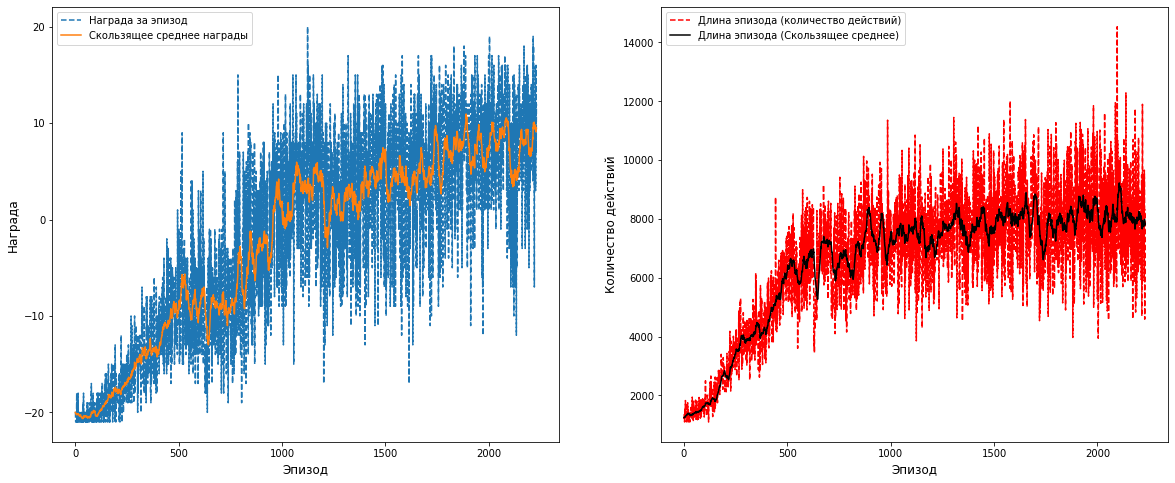

Закончен 2232-й эпизод, счёт: (агент) 21 - 9 (противник), продолжительность игры: 8328 кадров.


In [ ]:
env = gym.make('Pong-v4')     #Создаем среду Pong
while True:
  episode_states = []         #Создаем список где будут храниться все состояния одного эпизода (используется для обучения алгоритма)
  episode_actions = []        #Создаем список где будут храниться все действия за эпизод (используется для обучения алгоритма)
  episode_probabilities = []  #Создаем список где будут храниться вероятности для всех выбранных действий (используется для обучения алгоритма)
  episode_rewards = []        #Создаем список где будут храниться все награды за эпизод (используется для обучения алгоритма)

  new_frame = env.reset()          #Запускаем среду (это действие возвращает начальное состояние)
  old_frame = new_frame            #Инициализируем предыдущий кадр как текущий кадр

  done = False               #done - переменная говорит, если игровой эпизод завершён. Инициализируется с значением False.
  while not done:            #Пока игровой эпизод не завершён:
    state = stack_frames(new_frame, old_frame)         #Создаем новое состояние, используя новый кадр (это нужно делать после добавления состояния в массив)
    action_index, action_probability = choose_action(state)         #Выбираем индекс действия по текущему состоянию среды
    action = action_space[action_index]                             #Выбираем конкретное действие по индексу действия
    old_frame = new_frame                              #Записываем значение старого кадра как новый кадр (таким образом запонимаем старый кадр)
    new_frame, reward, done, misc = env.step(action)   #Подаем действие в среду, получаем новый кадр, награду, и узнаем если игра окончена.

    episode_states.append(state)                       #Добавляем состояние (с которым предсказывали действие) в массив состояний за эпизод.
    episode_probabilities.append(action_probability)   #Добавляем вероятность действия в список
    episode_actions.append(action_index)               #Добавляем действие в массив действий за эпизод.
    episode_rewards.append(reward)                     #Добавляем полученную награду в массив наград за эпизод.

  episode_number += 1                    #Увеличиваем счетчик (который отвечает за номер эпизода) на 1.
  episode_timesteps = len(episode_states)  #Длина эпизода (количество кадров в эпизоде) равно количеству состояний за эпизод.

  #Переводим данные в numpy массивы
  episode_states = np.array(episode_states)
  episode_actions = np.array(episode_actions)
  episode_rewards = np.array(episode_rewards)
  episode_probabilities = np.array(episode_probabilities)

  points_won = episode_rewards[episode_rewards > 0].size   #Считаем количество положительных наград (равно количеству голов, который забил агент)
  points_lost = episode_rewards[episode_rewards < 0].size  #Считаем количество отрициательных наград (равно количеству голов, который пропустил агент)

  # #Обучаем модель, используя состояния в эпизоде, соответствующие действия, награды, и предсказанные вероятности для каждого действия.
  train(episode_states, episode_actions, episode_rewards, episode_probabilities) 

  episode_score = points_won - points_lost         #Очки за эпизод = количество забитых голов - количество пропущенных голов
  all_scores.append(episode_score)                 #Добавляем количество очков в список (используется в качестве метрики)
  all_episode_durations.append(episode_timesteps)  #Добавляем длину эпизода в список (используется в качестве метрики)

  show_scores(all_scores, all_episode_durations)   #Отображаем метрики на графике

  model.save_weights('/content/drive/My Drive/pretrained_networks/ppo_pong/actor_critic.h5')   #Сохраняем веса модели
  with open('/content/drive/My Drive/pretrained_networks/ppo_pong/scores.txt', 'wb') as f:  #Открываем файл используя функцию из pickle
    pickle.dump([all_scores, all_episode_durations, episode_number], f)    #Записываем метрики (очки за эпизоды, длины эпизодов, и номер эпизода) в файл

  #Дополнительно выводим статистику за эпизод через print.
  print(f"Закончен {episode_number}-й эпизод, счёт: (агент) {points_won} - {points_lost} (противник), продолжительность игры: {episode_timesteps} кадров.")